In [1]:
import subprocess
import os
import yaml
from yaml.loader import FullLoader
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import time
from pdf2image import convert_from_path #(should be installed in cte env)
print('Running Cantera version: ' + ct.__version__)

######### Edit the 3 paths below ##############
species_dict_path = '/home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/species_dictionary.txt'
output_path='/home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/output.yml'
cantera_annottated_path='/home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/chem_annotated.cti'
###############################################

flux_diagram_folder_path=os.path.abspath(_)

home = os.getenv("HOME") or os.path.expanduser("~")
rmg_pypath = os.path.join(home, 'anaconda3', 'envs', 'rmg_env', 'bin', 'python')
if not os.path.isfile(rmg_pypath):
    raise Error('Could not find RMG-env')

######### Edit the path below ##############
command = [rmg_pypath, '/home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/background_script.py', species_dict_path]
############################################

completed_process = subprocess.run(command, shell=False, capture_output=True)

print("the terminal traceback: ",completed_process)


############### Edit the Shock Tube initial parameter ################
reactorTemperature = 1310  # Kelvin
reactorPressure = 3.92*101325.0  # Pascals
#Edit the Species labels by their SMILES except of Ar+Ne elements
# Define the fuel, oxidizer and set the stoichiometry:
gas_X = {'CC1=CC=C(C)O1': 0.01, '[O][O]': 0.075, 'Ar': 0.915}
######################################################################

Running Cantera version: 2.6.0
the terminal traceback:  CompletedProcess(args=['/home/nelly/anaconda3/envs/rmg_env/bin/python', '/home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/background_script.py', '/home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/species_dictionary.txt'], returncode=0, stdout=b'the images path:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/images\n', stderr=b'')


In [2]:
with open(output_path, 'r') as f:
    species_output_dict = yaml.load(stream=f, Loader=yaml.FullLoader)

for label in species_output_dict.keys():
    if label!='Ne' and label!='Ar': # to avoid brackets in the Ne and Ar elements in cti file
        search_text = label
        replace_text = species_output_dict[label] #smiles
        with open(cantera_annottated_path, 'r') as file:
            data = file.read()
            data = data.replace(search_text, replace_text)

        with open(cantera_annottated_path, 'w') as file:
            file.write(data)


In [3]:
def convert_pdf_2_png(smiles,pdf_path):
    """
    Cairo2D in RMG supports PDF (higher resolution than svg/png) 
    BUT, Graphiz DOT in Cantera doesnt support PDF
    SO, converting PDF image to png image results in better resolution than original png
    """
    pdf = convert_from_path(pdf_path, 300) #creates list
    pdf[0].save(f'{smiles}.png') #dpi=300


def pdf_smiles_2_png(species_output_dict,flux_diagram_folder_path):
    """
    This func goes over the pdf images in images folder, and converts each pdf image to png image
    """
    os.chdir(flux_diagram_folder_path+'/images')
    for smiles in species_output_dict.values():
        if smiles != "[Ne]" and smiles != "[Ar]": #avoiding parenthesis for elements
            convert_pdf_2_png(smiles,f'{smiles}.pdf')
        if smiles == "[Ne]":
            convert_pdf_2_png('Ne','Ne.pdf')
        if smiles == "[Ar]":
            convert_pdf_2_png('Ar','Ar.pdf')

In [4]:
# Define the ignition delay time (IDT). This function computes the ignition
# delay from the occurrence of the peak concentration for the specified species.
def ignitionDelay(states, species):
    i_ign = states(species).Y.argmax()
    return states.t[i_ign]


In [5]:
def shock_tube_simulation(estimatedIgnitionDelayTime,cantera_annottated_path,T,P,X):
    # Define the reactor temperature and pressure: Surjean 2013 Shock Tube first experiment out of 8
    reactorTemperature = T  # Kelvin
    reactorPressure = P  # Pascals

    # Load the real gas mechanism:
    gas = ct.Solution(cantera_annottated_path)
    # Set the state of the gas object:
    gas.TP = reactorTemperature, reactorPressure

    ##########Edit the Species labels by their SMILES except of Ar+Ne elements ##
    # Define the fuel, oxidizer and set the stoichiometry:
    #gas.X = {'CC1=CC=C(C)O1': 0.01, '[O][O]': 0.075, 'Ar': 0.915}
    gas.X=X
    #############################################################################

    # Create a reactor object and add it to a reactor network
    # In this example, this will be the only reactor in the network
    r = ct.Reactor(contents=gas)
    reactorNetwork = ct.ReactorNet([r])
    timeHistory = ct.SolutionArray(gas, extra=['t'])
    # Tic
    t0 = time.time()

    t = 0

    counter = 1
    while t < estimatedIgnitionDelayTime:
        t = reactorNetwork.step()
        if counter % 20 == 0:
            # We will save only every 20th value. Otherwise, this takes too long
            # Note that the species concentrations are mass fractions
            timeHistory.append(r.thermo.state, t=t)
        counter += 1

    # Toc
    t1 = time.time()
    time_computed=t1-t0
    return timeHistory,gas




In [6]:
def create_dot_and_png_files_in_t_dir(flux_diagram_folder_path,t,tau,gas):
    """
    This func creates a new folder to each t time interval. Inside that folder, 3 files are created:
    dot, modified_dot, and png file (the flux diagram itself)
    It's importatnt to note that the fluc diagram follows C element --> can be changed
    """
    time=str(np.format_float_scientific(tau*t, unique=False, precision=4))#scientific notation
    
    # Define the element to follow in the reaction path diagram:
    element = 'C'

    if t==1:
        t_path=flux_diagram_folder_path+"/tau"
    else:
        t_string=str(t)
        t_path=flux_diagram_folder_path+'/'+t_string+'tau'

    os.mkdir(t_path)
    print("t_path is: ",t_path, " t is: ",t)
    os.chdir(t_path)
    
    # Initiate the reaction path diagram:
    diagram = ct.ReactionPathDiagram(gas, element)
    diagram.font='CMU Serif Roman'
    diagram.threshold=1e-3
    diagram.dot_options='node[fontsize=10,shape="box"]'
    diagram.title = 'Reaction path diagram following {0} in t = '.format(element) + time + ' sec'

    print("starting creating files at: ",os.getcwd())
    dot_file = 'ReactionPathDiagram.dot'
    modified_dot_file = 'ReactionPathDiagramModified.dot'
    img_file = 'ReactionPathDiagram.png'
    
    # Write the dot-file first, then create the image from the dot-file with customizable parameters:
    diagram.write_dot(dot_file)
    return t_path

def insert_smiles_image_path_into_dot_file(smiles,content,t_flux_diagram_folder_path,flux_diagram_folder_path): 
    """
    This func gets a smiles label and the modified dot file content.
    Each variable in content list is a line from the modified dot file content
    It updates the content with the path to the smiles png image and returns it
    """
    os.chdir(t_flux_diagram_folder_path)

    for i,line in enumerate(content):
        if '"'+smiles+'"' in line: #smiles format of: '"C#C"' 
            index=line.find('label="') #one char index before label
            new_line=line[:index]+'label=""'+f' , image="{flux_diagram_folder_path}/images/{smiles}.png"];\n'
            content[i]=new_line              
    return content

def smiles_images_to_dot(species_output_dict,t_flux_diagram_folder_path,flux_diagram_folder_path):
    """
    This func reads the original dot file. All lines are in content variable (list).
    It goes over all the smiles and each smiles sends it to be modified and updated with the png image path in
    insert_smiles_image_path_into_dot_file func
    """
    os.chdir(t_flux_diagram_folder_path)

    infile = open("ReactionPathDiagram.dot", "r")
    infile_lines=infile.readlines()
    infile.close()
    content=infile_lines #list of lines in ReactionPathDiagram.dot
    
    for smiles in species_output_dict.values():
        content=insert_smiles_image_path_into_dot_file(smiles,content,t_flux_diagram_folder_path,flux_diagram_folder_path) #update the content for each smiles

    os.chdir(t_flux_diagram_folder_path) 
    with open(r'ReactionPathDiagramModified.dot', 'w') as outfile:
        outfile.writelines(content)

def dot_png_command(t_flux_diagram_folder_path):
    """
    The last command requires dot to be in your system path variables, or your system
    will not undersand the command "dot".
    The command -Tpng defines the filetype and needs to fit your filename defined above,
    or else you will get errors opening the file later.
    The command -Gdpi sets the resolution of the generated image in dpi.
    """
    os.chdir(t_flux_diagram_folder_path)
    modified_dot_file = 'ReactionPathDiagramModified.dot'
    img_file = 'ReactionPathDiagram.png'
    os.system('dot {0} -Tpng -o{1} -Gdpi=300'.format(modified_dot_file, img_file))

In [7]:
def shock_tube_idt_find_tau(cantera_annottated_path,T,P,X):
    """
    This func finds tau in shock tube reactor. If you do not get an ignition within this time,
    increase estimatedIgnitionDelayTime.
    Let's start by finding the IDT in the first run
    """
    estimatedIgnitionDelayTime = 0.005
    timeHistory=shock_tube_simulation(estimatedIgnitionDelayTime,cantera_annottated_path,T,P,X)[0]
     # We will use the 'OH' species to compute the ignition delay
    tau = ignitionDelay(timeHistory, '[OH]')
    print("The tau is: ", tau)

    ### Plot the result
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['font.family'] = 'serif'

    #Figure illustrating the definition of ignition delay time (IDT).
    plt.figure()
    plt.plot(timeHistory.t, timeHistory('[OH]').Y, '-o', color='b', markersize=4)
    plt.xlabel('Time (s)')
    plt.ylabel(r'[OH] mass fraction, $\mathdefault{Y_{OH}}$')
    ax = plt.gca()
    plt.savefig(os.path.dirname(cantera_annottated_path)+'/idt_plot.png',dpi=300)
    plt.show()
    return tau


In [8]:
def shock_tube_time_intervals(species_output_dict,flux_diagram_folder_path,cantera_annottated_path,T,P,X):
    """
    This func creates 11 intervals of time: [0.5*tau, 0.6*tau,...,tau, 1.1*tau,...1.5*tau]
    Each time is sent to shock_tube_simulation func to simulate the system at that time.
    After that, for each time, flux diagram is created
    """
    tau=shock_tube_idt_find_tau(cantera_annottated_path,T,P,X)
    time_interval_array=np.arange(0.5, 1.6, 0.1).tolist()
    time_interval_array=np.round(time_interval_array, 1).tolist()
    for t in time_interval_array:
        gas=shock_tube_simulation(t*tau,cantera_annottated_path,T,P,X)[1]
        #send it to the dot graphs, give t for the name of the folder and give tau for comuting,give gas
        t_path=create_dot_and_png_files_in_t_dir(flux_diagram_folder_path,t,tau,gas)
        smiles_images_to_dot(species_output_dict,t_path,flux_diagram_folder_path)
        dot_png_command(t_path)
        
    

/tmp/ipykernel_151169/1827723813.py:7: DeprecationWarning: XML_Node::build: 
The CTI and XML input file formats are deprecated and will be removed in
Cantera 3.0. Use 'cti2yaml.py' or 'ctml2yaml.py' to convert CTI or XML input
files to the YAML format. See https://cantera.org/tutorials/legacy2yaml.html
for more information.
  gas = ct.Solution(cantera_annottated_path)


The tau is:  0.0007525598809565267


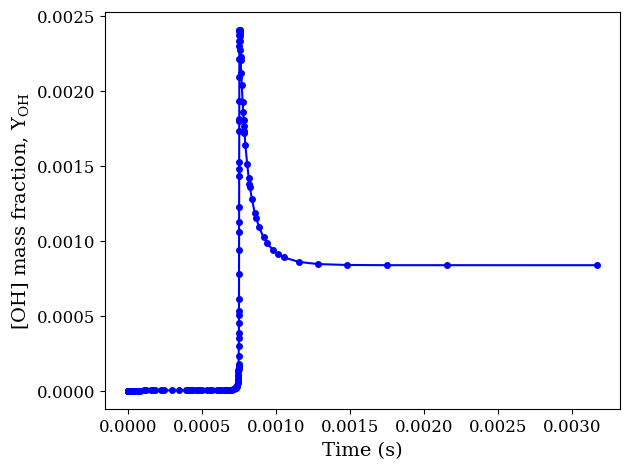

t_path is:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/0.5tau  t is:  0.5
starting creating files at:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/0.5tau


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.997564 to fit


t_path is:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/0.6tau  t is:  0.6
starting creating files at:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/0.6tau


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.997564 to fit


t_path is:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/0.7tau  t is:  0.7
starting creating files at:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/0.7tau


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.962151 to fit


t_path is:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/0.8tau  t is:  0.8
starting creating files at:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/0.8tau


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.988775 to fit


t_path is:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/0.9tau  t is:  0.9
starting creating files at:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/0.9tau


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.865775 to fit


t_path is:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/tau  t is:  1.0
starting creating files at:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/tau
t_path is:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/1.1tau  t is:  1.1
starting creating files at:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/1.1tau
t_path is:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/1.2tau  t is:  1.2
starting creating files at:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/1.2tau
t_path is:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/1.3tau  t is:  1.3
starting creating files at:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/1.3tau
t_path is:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/1.4tau  t is:  1.4
starting creating files at:  /home/nelly/OneDrive/Linux backup/scripts/Cantera/Flux diagram/1.4tau
t_path is:  /home/nelly/OneDrive/Linux ba

In [9]:
pdf_smiles_2_png(species_output_dict,flux_diagram_folder_path)
shock_tube_time_intervals(species_output_dict,flux_diagram_folder_path,cantera_annottated_path,reactorTemperature,reactorPressure,gas_X)
